# Section 1: Importing libraries and loading data 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 1.1 Loading data and specifying label names

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Data directory
DATADIR = 'UCI_HAR_Dataset'


# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'drive/My Drive/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))
# Utility function to print the confusion matrix

## 1.2 Reading Data

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'drive/My Drive/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

#=============================================================

def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

# Section 2: Tensoflow backend and utility functions

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Importing libraries
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization

Using TensorFlow backend.


In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print('Number of timesteps are for each of the input dimensions',timesteps)
print('the input dimensions are ',input_dim)
print('size of training data is:',len(X_train))

Number of timesteps are for each of the input dimensions 128
the input dimensions are  9
size of training data is: 7352


In [0]:
import warnings
warnings.filterwarnings('ignore')


#function for saving and opening the file
import pickle
def savetofile(obj,filename):
  pickle.dump(obj,open(filename+".p",'wb'))
  
def openfromfile(filename):
  temp = pickle.load(open(filename+".p",'rb'))
  return temp

In [0]:
# Initializing batch size and number of epochs for all the models
epochs = 30
batch_size = 16


In [0]:
#functions to plot confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,accuracy_score
plt.rcParams["font.family"] = 'DejaVu Sans'

def plt_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
#plotting the accuracy and classification report

from datetime import datetime
def perform_model(y_test,y_pred, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    results = dict()
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(y_test, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(y_pred, axis=1)])
    # calculate overall accuracty of the model
    accuracy = accuracy_score(y_true=Y_true, y_pred=Y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('For test data')
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    #plt.figure(figsize=(8,8))
    #plt.grid(b=False)
    #plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    #plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    class_report = classification_report(Y_true, Y_pred)
    # store report in results
    results['class_report'] = classification_report
    print(class_report)
    
    # add the trained  model to the results
    #results['model'] = model
    
    return results,cm

    
    

# Section 3: Deep learning Architecture and Models

so we will be implememting 4 different architectures here with different batchnormalization layers and dropout rates,and optimizers

## 3.1 Model 1:  LSTM(32) + Batchnormalization + Dropout(0.3) + RmsProp

In [0]:
# Initiliazing the sequential model
n_hidden = 32
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))


# Adding a BatchNormalization layer
model.add(BatchNormalization())

#adding a dropout layer
model.add(Dropout(0.3))

# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,702
Trainable params: 5,638
Non-trainable params: 64
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


# Training the model
history_1 = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/30




7352/7352 [==============================] - 119s 16ms/step - loss: 1.0557 - acc: 0.5335 - val_loss: 0.8607 - val_acc: 0.5881
Epoch 2/30
7352/7352 [==============================] - 102s 14ms/step - loss: 0.7560 - acc: 0.5817 - val_loss: 0.7688 - val_acc: 0.6098
Epoch 3/30
7352/7352 [==============================] - 99s 13ms/step - loss: 0.6784 - acc: 0.6178 - val_loss: 0.6830 - val_acc: 0.6485
Epoch 4/30
7352/7352 [==============================] - 98s 13ms/step - loss: 0.5846 - acc: 0.7167 - val_loss: 0.6987 - val_acc: 0.6980
Epoch 5/30
7352/7352 [==============================] - 106s 14ms/step - loss: 0.3940 - acc: 0.8414 - val_loss: 0.4036 - val_acc: 0.8521
Epoch 6/30
7352/7352 [==============================] - 107s 15ms/step - loss: 0.2726 - acc: 0.9132 - val_loss: 0.4896 - val_acc: 0.8578
Epoch 7/30
7352/7352 [========

In [0]:
score = model_1.evaluate(X_test,Y_test)
print('loss on test data is',score[0])
print('Accuracy on test data is:',score[1])


2947/2947 [==============================] - 2s 776us/step
loss on test data is 0.409051617424
Accuracy on test data is: 0.905666779776


In [0]:
model_1 = openfromfile('model_lstm1')#getting the saved model

For test data
---------------------
|      Accuracy      |
---------------------

    0.9056667797760435


--------------------
| Confusion Matrix |
--------------------

 Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 509        1        27        0                   0   
SITTING                  0      418        72        1                   0   
STANDING                 0      114       417        1                   0   
WALKING                  0        0         0      466                   0   
WALKING_DOWNSTAIRS       0        0         0        0                 401   
WALKING_UPSTAIRS         0        4         0        8                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING 

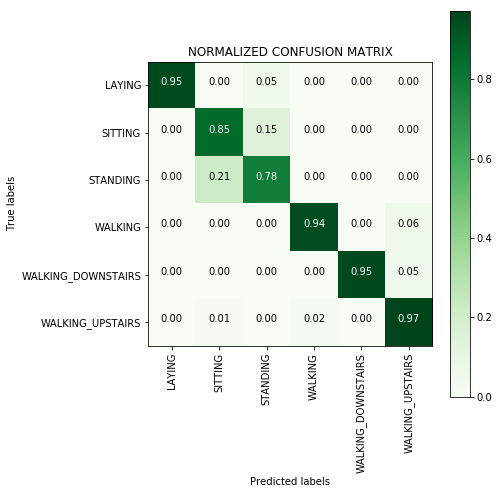

In [0]:
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
y_pred=model_1.predict(X_test)
results_mod_1,cm_1 =  perform_model(Y_test,y_pred,labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens)


#Get the confusion matrix

cm_df=confusion_matrix(Y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df

#Plot a Non-Normalized confusion matrix
#plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX")

#Plot a Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX")

## 3.2 : LSTM(80 cells) + LSTM (35 cells) + Dropout(0.4) +Dropout(0.2) + 1 BatchNormalization layers + Adam Optimizer

 

In [0]:
from keras.layers import BatchNormalization

model = Sequential()

model.add(LSTM(80,input_shape =(timesteps,input_dim),return_sequences = True ))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(LSTM(35))
model.add(Dropout(0.2))

model.add(Dense(n_classes,activation = 'sigmoid'))#adding the output layer
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 80)           28800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 80)           320       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 80)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 35)                16240     
_________________________________________________________________
dropout_3 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 216       
Total params: 45,576
Trainable params: 45,416
Non-trainable params: 160
________________________________________________

In [0]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
history = model.fit(X_train,Y_train,batch_size = batch_size,validation_data = (X_test,Y_test),
                    epochs = epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 208s 28ms/step - loss: 0.9093 - acc: 0.7252 - val_loss: 0.5509 - val_acc: 0.8582
Epoch 2/30
7352/7352 [==============================] - 203s 28ms/step - loss: 0.3749 - acc: 0.8898 - val_loss: 0.9213 - val_acc: 0.6827
Epoch 3/30
7352/7352 [==============================] - 208s 28ms/step - loss: 0.2522 - acc: 0.9208 - val_loss: 0.3453 - val_acc: 0.8884
Epoch 4/30
7352/7352 [==============================] - 209s 28ms/step - loss: 0.2355 - acc: 0.9223 - val_loss: 0.2817 - val_acc: 0.9094
Epoch 5/30
7352/7352 [==============================] - 211s 29ms/step - loss: 0.2029 - acc: 0.9285 - val_loss: 0.3546 - val_acc: 0.8809
Epoch 6/30
7352/7352 [==============================] - 210s 29ms/step - loss: 0.1750 - acc: 0.9357 - val_loss: 0.3565 - val_acc: 0.8968
Epoch 7/30
7352/7352 [==============================] - 209s 28ms/step - loss: 0.1619 - acc: 0.9404 - val_loss: 0.2893 - val_acc: 

In [0]:
score = model.evaluate(X_test,Y_test)
print('loss on test data is',score[0])
print('Accuracy on test data is:',score[1])


history_lstm2 = savetofile(history,'history_lstm2')
model_lstm2 = savetofile(model,'model_lstm2')

2947/2947 [==============================] - 12s 4ms/step
loss on test data is 0.24302211337054586
Accuracy on test data is: 0.9121140142517815


In [0]:
model_2 = openfromfile('model_lstm2')
#history_2 = openfromfile('history_lstm2')


For test data
---------------------
|      Accuracy      |
---------------------

    0.9121140142517815


--------------------
| Confusion Matrix |
--------------------

 Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  6      423        61        0                   0   
STANDING                 0      129       402        1                   0   
WALKING                  0        0         0      478                  17   
WALKING_DOWNSTAIRS       0        0         0        2                 417   
WALKING_UPSTAIRS         0        0         0       15                  25   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING 

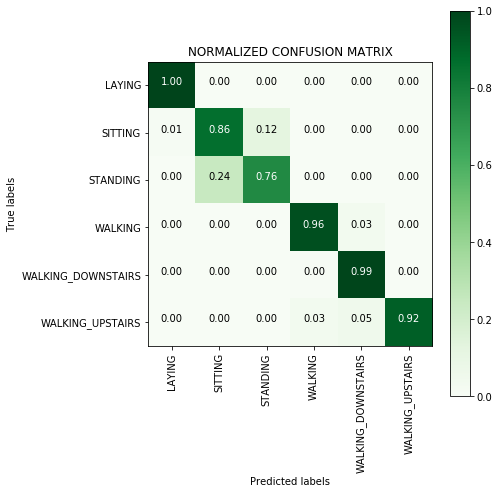

In [0]:
y_pred=model_2.predict(X_test)
results_mod_2,cm_2 =  perform_model(Y_test,y_pred,labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens)


#Get the confusion matrix

cm_df=confusion_matrix(Y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df

#Plot a Non-Normalized confusion matrix
#plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX")

#Plot a Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX")

 ## 3.3: Conv1d(64) +Conv1d(48) +Maxpooling(2) + Batchnormalization + Dropout(0.5) +Dense(100)

In [0]:
#implementing 1 dimensional convnet with 3d tensor as input
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.initializers import he_normal
from keras.layers import BatchNormalization


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
#defining the model
# we will be tuning the model with different number of filters and different size 

model = Sequential()
model.add(Conv1D(filters = 64,kernel_size = 3,activation = 'relu',kernel_initializer = he_normal(seed = None),input_shape = (timesteps,input_dim)))
model.add(Conv1D(filters = 48,kernel_size = 3,activation = 'relu',kernel_initializer = he_normal(seed = None)))
model.add(MaxPooling1D(pool_size = 2))
model.add(BatchNormalization())

#adding the dropout layer
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100,activation = 'relu',kernel_initializer = he_normal(seed = None)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes,activation = 'softmax'))

print(model.summary())

#compiling with adam optimizer 

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
history = model.fit(X_train,Y_train,batch_size = batch_size,epochs = epochs,validation_data = (X_test,Y_test))



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 64)           1792      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 48)           9264      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 48)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 48)            192       
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 48)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2976)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)            

In [0]:
score = model.evaluate(X_test,Y_test)
print('Loss on test data is:',score[0])
print('accuracy on test data is:',score[1])

2947/2947 [==============================] - 0s 117us/step
Loss on test data is: 0.3845438683092381
accuracy on test data is: 0.9090600610790635


In [0]:
history_cnn = savetofile(history,'history_cnn')
model_cnn = savetofile(model,'model_cnn')

In [0]:
model_3 = openfromfile('model_cnn')
#history_3 = openfromfile('history_cnn')

For test data
---------------------
|      Accuracy      |
---------------------

    0.9090600610790635


--------------------
| Confusion Matrix |
--------------------

 Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      399        66        0                   0   
STANDING                 0      115       409        1                   0   
WALKING                  0        0         0      469                  26   
WALKING_DOWNSTAIRS       0        0         0        0                 418   
WALKING_UPSTAIRS         0        0         0        0                  24   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                           26  
STANDING                           7  
WALKING 

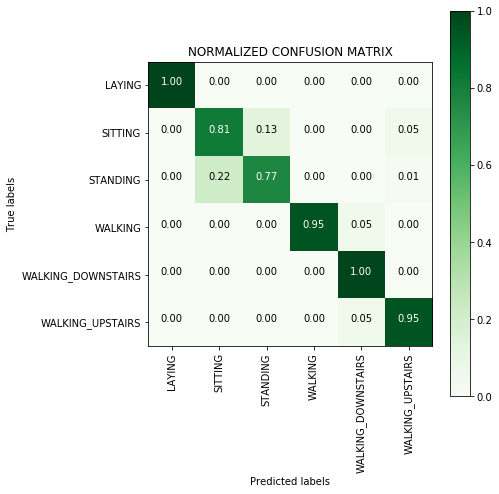

In [0]:
y_pred=model_3.predict(X_test)
results_mod_3,cm_3 =  perform_model(Y_test,y_pred,labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens)


#Get the confusion matrix

cm_df=confusion_matrix(Y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df

#Plot a Non-Normalized confusion matrix
#plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX")

#Plot a Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX")

## 3.4 LSTM(100) + Dropout(0.7) + LSTM(50) + Dropout(0.7) + RmsProp

In [0]:
from keras.regularizers import L1L2
reg = L1L2(0.01,0.01)

In [0]:
model = Sequential()
model.add(LSTM(100, input_shape=(timesteps, input_dim), kernel_initializer='glorot_normal' , return_sequences=True, bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.70))
model.add(LSTM(50))
model.add(Dropout(0.70))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 100)          44000     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 100)          400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 74,906
Trainable params: 74,706
Non-trainable params: 200
______________________________________________________

In [0]:
 #Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
#checkpoint_3 = ModelCheckpoint("model_7.h5",monitor="val_acc",mode="max",save_best_only = True,verbose=1)
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=30)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 142s 19ms/step - loss: 1.7124 - acc: 0.8491 - val_loss: 1.1561 - val_acc: 0.8787
Epoch 2/30
7352/7352 [==============================] - 155s 21ms/step - loss: 0.6482 - acc: 0.9057 - val_loss: 0.2787 - val_acc: 0.9185
Epoch 3/30
7352/7352 [==============================] - 149s 20ms/step - loss: 0.1732 - acc: 0.9380 - val_loss: 0.1416 - val_acc: 0.9497
Epoch 4/30
7352/7352 [==============================] - 144s 20ms/step - loss: 0.1283 - acc: 0.9560 - val_loss: 0.2491 - val_acc: 0.9179
Epoch 5/30
7352/7352 [==============================] - 139s 19ms/step - loss: 0.1061 - acc: 0.9635 - val_loss: 0.1095 - val_acc: 0.9603
Epoch 6/30
7352/7352 [==============================] - 142s 19ms/step - loss: 0.0932 - acc: 0.9675 - val_loss: 0.0858 - val_acc: 0.9711
Epoch 7/30
7352/7352 [==============================] - 147s 20ms/step - loss: 0.0934 - acc: 0.9688 - val_loss: 0.1242 - val_acc: 

In [0]:
model_4 = openfromfile('model_final')
history_4 = openfromfile('history_final')

In [0]:
model_final = savetofile(model,'model_final')
history_final = savetofile(history,'history_final')

# Section 4: Plotting the error and accuracy

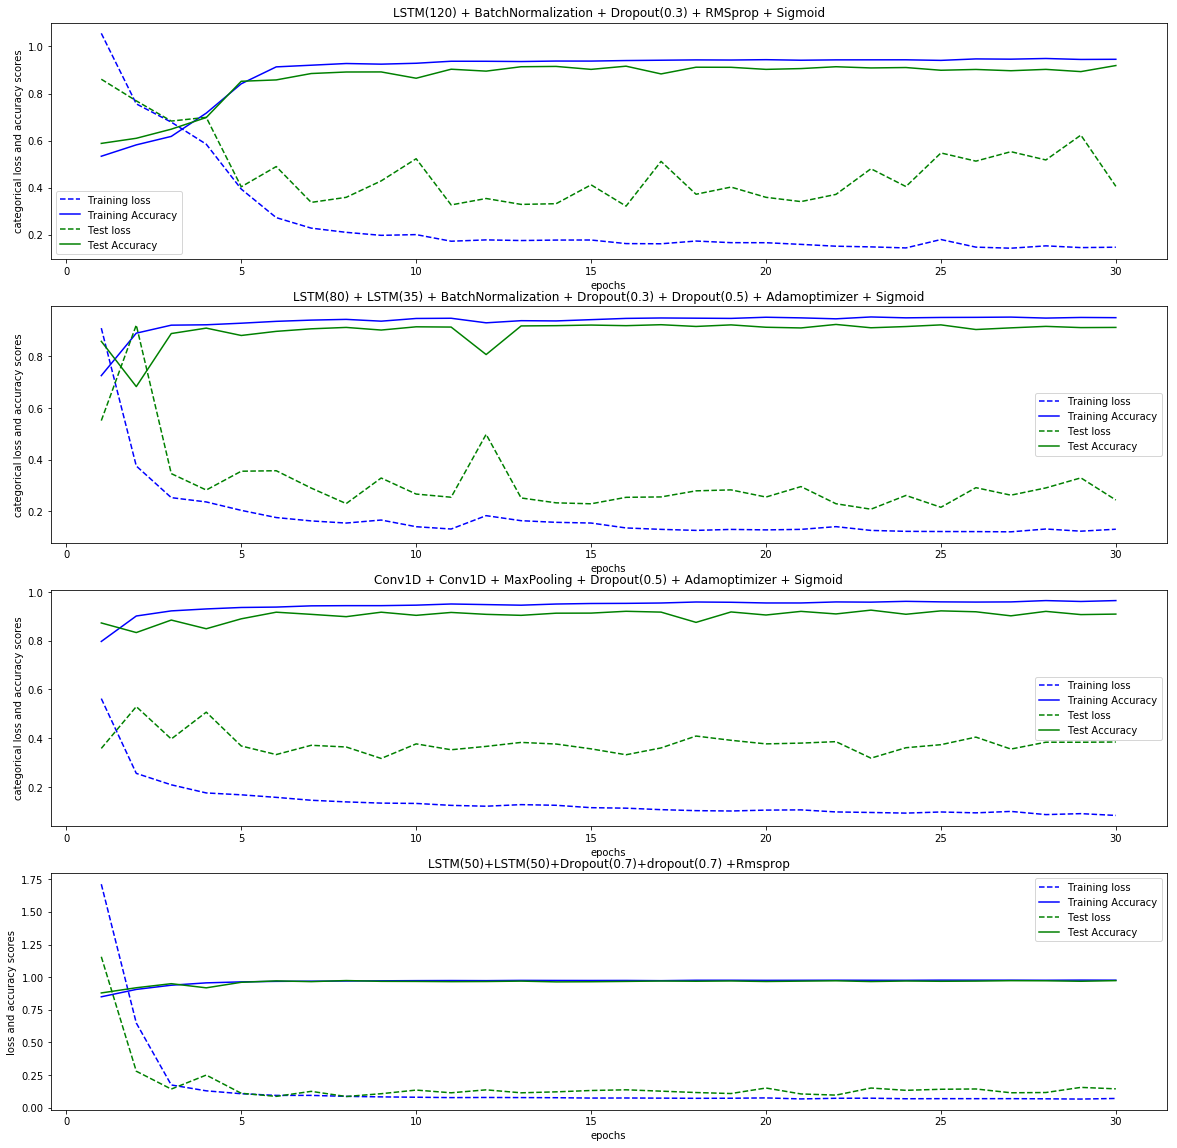

In [0]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
#plotting for all the models

x = list(range(1,epochs+1))

plt.figure(figsize  = (20,20))
plt.subplot(4,1,1)
plt.title('LSTM(120) + BatchNormalization + Dropout(0.3) + RMSprop + Sigmoid',size = 12)
#plt.grid()
plt.plot(x,openfromfile("history_1").history['loss'],'b--',label = 'Training loss')
plt.plot(x,openfromfile("history_1").history['acc'],'b',label = 'Training Accuracy')
plt.plot(x,openfromfile("history_1").history['val_loss'],'g--',label = 'Test loss')
plt.plot(x,openfromfile("history_1").history['val_acc'],'g',label = 'Test Accuracy')
plt.xlabel('epochs')
plt.ylabel('categorical loss and accuracy scores')
plt.legend(loc = 'best')
print('\n\n')




plt.subplot(4,1,2)
plt.title('LSTM(80) + LSTM(35) + BatchNormalization + Dropout(0.3) + Dropout(0.5) + Adamoptimizer + Sigmoid',size = 12)
#plt.grid()
plt.plot(x,openfromfile("history_lstm2").history['loss'],'b--',label = 'Training loss')
plt.plot(x,openfromfile("history_lstm2").history['acc'],'b',label = 'Training Accuracy')
plt.plot(x,openfromfile("history_lstm2").history['val_loss'],'g--',label = 'Test loss')
plt.plot(x,openfromfile("history_lstm2").history['val_acc'],'g',label = 'Test Accuracy')
plt.xlabel('epochs')
plt.ylabel('categorical loss and accuracy scores')
plt.legend(loc = 'best')
print('\n\n')



#cnn
plt.subplot(4,1,3)
plt.title('Conv1D + Conv1D + MaxPooling + Dropout(0.5) + Adamoptimizer + Sigmoid',size = 12)
#plt.grid()
plt.plot(x,openfromfile("history_cnn").history['loss'],'b--',label = 'Training loss')
plt.plot(x,openfromfile("history_cnn").history['acc'],'b',label = 'Training Accuracy')
plt.plot(x,openfromfile("history_cnn").history['val_loss'],'g--',label = 'Test loss')
plt.plot(x,openfromfile("history_cnn").history['val_acc'],'g',label = 'Test Accuracy')
plt.xlabel('epochs')
plt.ylabel('categorical loss and accuracy scores')
plt.legend(loc = 'best')
print('\n\n')
#plt.show()

#
plt.subplot(4,1,4)
plt.title('LSTM(50)+LSTM(50)+Dropout(0.7)+dropout(0.7) +Rmsprop',size = 12)
plt.plot(x,openfromfile("history_final").history['loss'],'b--',label = 'Training loss')
plt.plot(x,openfromfile("history_final").history['acc'],'b',label = 'Training Accuracy')
plt.plot(x,openfromfile("history_final").history['val_loss'],'g--',label = 'Test loss')
plt.plot(x,openfromfile("history_final").history['val_acc'],'g',label = 'Test Accuracy')
plt.xlabel('epochs')
plt.ylabel('loss and accuracy scores')
plt.legend(loc = 'best')
plt.show()


## Conclusion

In [0]:
# Conclusio
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ['Architecture','optimizer','loss','test accuracy']
table.add_row(['LSTM(32) + Dropout(0.3) + BatchNormaliztion','RMSprop','categorical cross entropy',0.905])
table.add_row(['LSTM(80) + Dropout(0.2) + LSTM(50) + Dropout(0.4)','Adam','categorical cross entropy',0.9121])
table.add_row(['Conv1D + Conv1D + MaxPooling + Dropout(0.5)',"Adam",'categorical cross entropy',0.9091])
table.add_row(['LSTM(100)+LSTM(50)+Dropout(0.7)+Dropout(0.7)','Rmsprop','bianry cross entropy',0.9682])
print(table)

+---------------------------------------------------+-----------+---------------------------+---------------+
|                    Architecture                   | optimizer |            loss           | test accuracy |
+---------------------------------------------------+-----------+---------------------------+---------------+
|    LSTM(32) + Dropout(0.3) + BatchNormaliztion    |  RMSprop  | categorical cross entropy |     0.905     |
| LSTM(80) + Dropout(0.2) + LSTM(50) + Dropout(0.4) |    Adam   | categorical cross entropy |     0.9121    |
|    Conv1D + Conv1D + MaxPooling + Dropout(0.5)    |    Adam   | categorical cross entropy |     0.9091    |
|    LSTM(100)+LSTM(50)+Dropout(0.7)+Dropout(0.7)   |  Rmsprop  |    bianry cross entropy   |     0.9682    |
+---------------------------------------------------+-----------+---------------------------+---------------+


This project is to build a model that predicts the human activities such as Walking, Walking_Upstairs, Walking_Downstairs, Sitting, Standing or Laying.

This dataset is collected from 30 persons(referred as subjects in this dataset), performing different activities with a smartphone to their waists. The data is recorded with the help of sensors (accelerometer and Gyroscope) in that smartphone. This experiment was video recorded to label the data manually.



The startegy we employed for classification with help of deep learning models is we implemented 4 different models,3 with LSTM units and 1 with Conv1d.We tried hyper parameter tuing with hyperas also .

Finally we were able to get best accuracy of 0.96

In [0]:
#3 Classification of static and dynamic activities 

# Classifiation of static and dynamic activities 

so we will be classifiying the activities in two parts,first is Dynamic activities and second are static activities using the divide and conqueor based approach 

In [0]:
## Classification dynamic activities

In [0]:
! pip install hyperas

In [0]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
warnings.simplefilter("ignore")

In [0]:
#saving data for loading it later in hyperas for hyper-parameter tuning
savetofile(X_train,'train')
savetofile(X_test,'test')
savetofile(Y_train,'train_y')
savetofile(Y_test,'test_y')

In [0]:
def data():
    x_train = pickle.load(open('train'+".p",'rb'))
    y_train = pickle.load(open('train_y'+".p",'rb'))
    x_test =  pickle.load(open("test"+".p",'rb'))
    y_test =  pickle.load(open("test_y"+".p",'rb'))
    return x_train, y_train, x_test, y_test

In [0]:
#we tried the hyperparameter tuning but it is not working in this case as some error is occuring with notebook path multiple times
#this is the code I tried to implement gethering from multiple sources
#following source helped me to tune the parameters - https://towardsdatascience.com/keras-hyperparameter-tuning-in-google-colab-using-hyperas-624fa4bbf673
"""
def create_model(x_train, y_train, x_test, y_test):
    
    epochs = 8
    batch_size = 32
    timesteps = x_train.shape[1]
    input_dim = len(x_train[0][0])
    n_classes = 6
    
    model = Sequential()
    
    model.add(LSTM(64, return_sequences = True, input_shape = (timesteps, input_dim)))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(LSTM({{choice([32, 16])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense(n_classes, activation='sigmoid'))
    
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')
    
    result = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, verbose=2, validation_split=0.01)
    
    validation_acc = np.amax(result.history['val_acc']) 
    
    print('Best validation acc of epoch:', validation_acc)
    
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}
    """

In [0]:
"""
import warnings
warnings.filterwarnings('ignore')
best_run, best_model = optim.minimize(model=create_model, data=data, algo=tpe.suggest, max_evals=4, trials=Trials(), notebook_name = "drive/My Drive/Colab Notebooks/HAR_LSTM")
x_train, y_train, x_test, y_test = data()

score = best_model.evaluate(x_test, y_test)

print('---------------------')
print('|      Accuracy      |')
print('---------------------')
acc = np.round((score[1]*100), 2)
print(str(acc)+"%\n")
    
print('----------------------------------')
print('|      Best Hyper-Parameters      |')
print('----------------------------------')
print(best_run)
print("\n\n")

true_labels = [np.argmax(i)+1 for i in y_test]
predicted_probs = best_model.predict(x_test)
predicted_labels = [np.argmax(i)+1 for i in predicted_probs]
print_confusionMatrix(true_labels, predicted_labels)
"""

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from google.colab import drive
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from keras.layers.core import Dense, Dropout
except:
    pass

try:
    from keras.layers import BatchNormalization
except:
    pass

try:
    import warnings
except:
    pass

try:
    import pickle
except:
    pass

try:
    import itertools
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    from sklearn.metrics import classification_report, accuracy_score
except:
  

KeyboardInterrupt: ignored

# Classifying the activities in Static and Dynamic and then combinig both the models using divide and conquer based approach

In [0]:
#initializing the session
tf.set_random_seed(0)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)



## 2 class classification

In [0]:
## Classifying data as 2 class dynamic vs static 
##data preparation
    
def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        """
        filename = f'drive/My Drive/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y[y<=3] = 0 #for all dynamic activities
        y[y>3] = 1 #for all stattic activities
        return pd.get_dummies(y).as_matrix()#getting thee matrix 
    
x_train,x_test = load_signals('train'), load_signals('test')
y_train,y_test = load_y('train'), load_y('test')
print(x_train.shape)
print(x_test.shape)

(7352, 2)
(2947, 2)


## Architecture 1 with adam optimizer for classifying 2 classes

In [0]:

sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model_2c = Sequential()
model_2c.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9),bias_regularizer=reg))
model_2c.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model_2c.add(Dropout(0.6))
model_2c.add(MaxPooling1D(pool_size=2))
model_2c.add(Flatten())
model_2c.add(Dense(50, activation='relu'))
model_2c.add(Dense(2, activation='softmax'))
model_2c.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                99250     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [0]:
model_2c.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2c.fit(x_train,y_train, epochs=20, batch_size=16,validation_data=(x_test, y_test), verbose=1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 3s 382us/step - loss: 0.0571 - acc: 0.9778 - val_loss: 0.0136 - val_acc: 0.9976
Epoch 2/20
7352/7352 [==============================] - 2s 337us/step - loss: 0.0033 - acc: 0.9992 - val_loss: 0.0169 - val_acc: 0.9932
Epoch 3/20
7352/7352 [==============================] - 3s 355us/step - loss: 9.8120e-04 - acc: 0.9995 - val_loss: 0.0345 - val_acc: 0.9888
Epoch 4/20
7352/7352 [==============================] - 3s 358us/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0192 - val_acc: 0.9936
Epoch 5/20
7352/7352 [==============================] - 2s 338us/step - loss: 5.9842e-05 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9898
Epoch 6/20
7352/7352 [==============================] - 2s 331us/step - loss: 4.4741e-05 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9895
Epoch 7/20
7352/7352 [==============================] - 2s 325us/step - loss: 5.2726e-05 - acc: 1.0000 - val_loss: 0.0284 - 

In [0]:
#saving model
model_2c.save('final_model_2c.h5')

## Classifying the static activities

In [0]:

def load_y(subset):
"""
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
    filename = f'drive/My Drive/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y_subset = y>3 #for static activities
    y = y[y_subset]
    return pd.get_dummies(y).as_matrix(),y_subset
    
Y_train_s,y_train_sub = load_y('train')
Y_val_s,y_test_sub = load_y('test')
X_train_s, X_val_s = load_signals('train'), load_signals('test')
X_train_s = X_train_s[y_train_sub]
X_val_s = X_val_s[y_test_sub]
    


## Architecture 2 with adam optimizer

In [0]:
np.random.seed(0)
#tf.set_random_seed(0)
#sess = tf.Session(graph=tf.get_default_graph())
#K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=96, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.7))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 122, 128)          8192      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 120, 96)           36960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 96)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 40, 96)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                115230    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                

In [0]:
import math
#adam = optimizers.Adam(lr=0.004)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_s,Y_train_s, epochs=100, batch_size=32,validation_data=(X_val_s, Y_val_s), verbose=1)
#K.clear_session()


Train on 4067 samples, validate on 1560 samples
Epoch 1/100
4067/4067 [==============================] - 1s 292us/step - loss: 0.3541 - acc: 0.8785 - val_loss: 0.3553 - val_acc: 0.8814
Epoch 2/100
4067/4067 [==============================] - 1s 198us/step - loss: 0.2323 - acc: 0.9142 - val_loss: 0.2968 - val_acc: 0.9006
Epoch 3/100
4067/4067 [==============================] - 1s 182us/step - loss: 0.1686 - acc: 0.9343 - val_loss: 0.2738 - val_acc: 0.9058
Epoch 4/100
4067/4067 [==============================] - 1s 173us/step - loss: 0.2100 - acc: 0.9343 - val_loss: 0.2724 - val_acc: 0.9083
Epoch 5/100
4067/4067 [==============================] - 1s 185us/step - loss: 0.1412 - acc: 0.9452 - val_loss: 0.2368 - val_acc: 0.9192
Epoch 6/100
4067/4067 [==============================] - 1s 170us/step - loss: 0.1148 - acc: 0.9577 - val_loss: 0.2803 - val_acc: 0.9115
Epoch 7/100
4067/4067 [==============================] - 1s 178us/step - loss: 0.1630 - acc: 0.9466 - val_loss: 0.1862 - val_acc: 

In [0]:
#saving model
model.save('final_model_static.h5')

## Classifyinf dynamic activities 

In [0]:
##data preparation
def load_y(subset):

    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    """
  filename = f'drive/My Drive/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
  y = _read_csv(filename)[0]
  y_subset = y<=3 #classifying for  dynamic activities 
  y = y[y_subset]
  return pd.get_dummies(y).as_matrix(),y_subset
    
Y_train_d,y_train_sub = load_y('train')
Y_val_d,y_test_sub = load_y('test')
X_train_d, X_val_d = load_signals('train'), load_signals('test')
X_train_d = X_train_d[y_train_sub]
X_val_d = X_val_d[y_test_sub]


## Architecture 3 with adam optimizer 

In [0]:
np.random.seed(0)
#tf.set_random_seed(0)
#sess = tf.Session(graph=tf.get_default_graph())
#K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 122, 64)           4096      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 120, 32)           6176      
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                38430     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                

In [0]:
import math
import keras
#adam = keras.optimizers.Adam(lr=0.004)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_s,Y_train_s, epochs=100, batch_size=32,validation_data=(X_val_s, Y_val_s), verbose=1)
#K.clear_session()

Train on 4067 samples, validate on 1560 samples
Epoch 1/100
4067/4067 [==============================] - 1s 255us/step - loss: 0.3476 - acc: 0.8670 - val_loss: 0.2779 - val_acc: 0.8994
Epoch 2/100
4067/4067 [==============================] - 1s 158us/step - loss: 0.2045 - acc: 0.9137 - val_loss: 0.2820 - val_acc: 0.9071
Epoch 3/100
4067/4067 [==============================] - 1s 170us/step - loss: 0.1711 - acc: 0.9265 - val_loss: 0.2314 - val_acc: 0.9147
Epoch 4/100
4067/4067 [==============================] - 1s 199us/step - loss: 0.1420 - acc: 0.9383 - val_loss: 0.2294 - val_acc: 0.9083
Epoch 5/100
4067/4067 [==============================] - 1s 160us/step - loss: 0.1276 - acc: 0.9493 - val_loss: 0.2400 - val_acc: 0.9090
Epoch 6/100
4067/4067 [==============================] - 1s 172us/step - loss: 0.1130 - acc: 0.9560 - val_loss: 0.2280 - val_acc: 0.9288
Epoch 7/100
4067/4067 [==============================] - 1s 180us/step - loss: 0.1322 - acc: 0.9466 - val_loss: 0.2019 - val_acc: 

In [0]:
#saving model
model.save('final_model_dynamic.h5')

## Final model and results 

In [0]:
#getting all the models
from keras.models import load_model
#getting the models
model_2class = load_model('final_model_2c.h5')
model_dynamic = load_model('final_model_dynamic.h5')
model_static = load_model('final_model_static.h5')
#for all the classses 
class_2 = pickle.load(open('2class.p','rb'))
static = pickle.load(open('static.p','rb'))
dynamic = pickle.load(open('dynamic.p','rb'))

In [0]:
#predicting output activity
def predict_activity(X):
    ##predicting whether dynamic or static
    predict_2class = model_2class.predict(transform_data(X,scale_2class))
    Y_pred_2class =  np.argmax(predict_2class, axis=1)
    #static data filter
    X_static = X[Y_pred_2class==1]
    #dynamic data filter
    X_dynamic = X[Y_pred_2class==0]
    #predicting static activities
    predict_static = model_static.predict(transform_data(X_static,scale_static))
    predict_static = np.argmax(predict_static,axis=1)
    #adding 4 because need to get inal prediction lable as output
    predict_static = predict_static + 4
    #predicting dynamic activites
    predict_dynamic = model_dynamic.predict(transform_data(X_dynamic,scale_dynamic))
    predict_dynamic = np.argmax(predict_dynamic,axis=1)
    #adding 1 because need to get inal prediction lable as output
    predict_dynamic = predict_dynamic + 1
    ##appending final output to one list in the same sequence of input data
    i,j = 0,0 
    final_pred = []
    for mask in Y_pred_2class:
        if mask == 1:
            final_pred.append(predict_static[i])
            i = i + 1
        else:
            final_pred.append(predict_dynamic[j])
            j = j + 1 
    return final_pred

In [0]:
##predicting 
final_pred_val = predict_activity(X_test)
final_pred_train = predict_activity(X_train)

In [1]:
##accuracy of train and test
from sklearn.metrics import accuracy_score
print('Accuracy of train data:',accuracy_score(Y_train,final_pred_train))
print('Accuracy of validation data:',accuracy_score(Y_val,final_pred_val))

Accuracy of train data: 0.963949945593036
Accuracy of validation data: 0.9518384798099763


## so here we finally get the best performing model with test accuracy of 0.95 and trainaccuracy of 0.96 using divide and conquer methods 